<a href="https://colab.research.google.com/github/alexandergribenchenko/DS_LATAM_Test/blob/main/solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A. Líbrerías

In [76]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

import warnings
warnings.filterwarnings("ignore")

# B. Dataframe raw

In [2]:
path_github = 'https://raw.githubusercontent.com/alexandergribenchenko/DS_LATAM_Test/main/dataset_SCL.csv'

In [3]:
df_raw = pd.read_csv(path_github, dtype=object)
df_raw

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68201,2017-12-22 14:55:00,400,SCEL,SPJC,JAT,2017-12-22 15:41:00,400.0,SCEL,SPJC,JAT,22,12,2017,Viernes,I,JetSmart SPA,Santiago,Lima
68202,2017-12-25 14:55:00,400,SCEL,SPJC,JAT,2017-12-25 15:11:00,400.0,SCEL,SPJC,JAT,25,12,2017,Lunes,I,JetSmart SPA,Santiago,Lima
68203,2017-12-27 14:55:00,400,SCEL,SPJC,JAT,2017-12-27 15:35:00,400.0,SCEL,SPJC,JAT,27,12,2017,Miercoles,I,JetSmart SPA,Santiago,Lima
68204,2017-12-29 14:55:00,400,SCEL,SPJC,JAT,2017-12-29 15:08:00,400.0,SCEL,SPJC,JAT,29,12,2017,Viernes,I,JetSmart SPA,Santiago,Lima


In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Fecha-I    68206 non-null  object
 1   Vlo-I      68206 non-null  object
 2   Ori-I      68206 non-null  object
 3   Des-I      68206 non-null  object
 4   Emp-I      68206 non-null  object
 5   Fecha-O    68206 non-null  object
 6   Vlo-O      68205 non-null  object
 7   Ori-O      68206 non-null  object
 8   Des-O      68206 non-null  object
 9   Emp-O      68206 non-null  object
 10  DIA        68206 non-null  object
 11  MES        68206 non-null  object
 12  AÑO        68206 non-null  object
 13  DIANOM     68206 non-null  object
 14  TIPOVUELO  68206 non-null  object
 15  OPERA      68206 non-null  object
 16  SIGLAORI   68206 non-null  object
 17  SIGLADES   68206 non-null  object
dtypes: object(18)
memory usage: 9.4+ MB


# Sección 01. Distribución de los datos

### 01.01. `Fecha-I`

In [5]:
# column_interest = 'Fecha-I'
# print(type(df_raw[column_interest][0]))
# print(df_raw[column_interest].nunique())
# print(sorted(list(df_raw[column_interest].unique())))
# df_raw[column_interest].value_counts(dropna=False, normalize=False)

### 02. Vlo-I

In [6]:
column_interest = 'Vlo-I'
print(type(df_raw[column_interest][0]))
print(df_raw[column_interest].nunique())
print(sorted(list(df_raw[column_interest].unique())))
df_raw[column_interest].value_counts(dropna=False, normalize=False)

<class 'str'>
584
['1', '10', '100', '1003', '1004', '1005', '1011', '102', '1025', '1031', '1033', '1034', '1035', '104', '1041', '1043', '1050', '1051', '1052', '1054', '106', '1061', '1065', '1071', '108', '1083', '1088', '1091', '1099', '11', '110', '1101', '1102', '1103', '1104', '1104A', '1105', '1106', '1107', '1108', '1111', '1113', '1114', '1115', '1116', '1117', '112', '1121', '1122', '1124', '1126', '1128', '1130', '1132', '1134', '1136', '1138', '114', '1140', '1141', '1142', '1146', '1148', '1149', '1151', '1154', '1155', '1158', '1159', '116', '1165', '1166', '1167', '1168', '1169', '1170', '1176', '1178', '118', '1186', '1188', '1191', '1193', '1195', '1197', '1198', '1199', '120', '1200', '1202', '1218', '122', '1222', '1224', '1226', '1228', '1230', '1233', '1234', '1235', '1236', '1237', '1238', '1239', '124', '1240', '1241', '1242', '1243', '1244', '1246', '1247', '1248', '1249', '1250', '1251', '1257', '1259', '126', '1260', '1261', '1262', '1264', '1267', '1269', '

174     686
11      645
116     608
150     557
704     556
       ... 
1121      1
1116      1
1065      1
1054      1
1234      1
Name: Vlo-I, Length: 584, dtype: int64

### 03. Ori-I

In [7]:
column_interest = 'Ori-I'
print(type(df_raw[column_interest][0]))
print(df_raw[column_interest].nunique())
print(sorted(list(df_raw[column_interest].unique())))
df_raw[column_interest].value_counts(dropna=False, normalize=False)

<class 'str'>
1
['SCEL']


SCEL    68206
Name: Ori-I, dtype: int64

### 04. Des-I

In [8]:
column_interest = 'Des-I'
print(type(df_raw[column_interest][0]))
print(df_raw[column_interest].nunique())
print(sorted(list(df_raw[column_interest].unique())))
df_raw[column_interest].value_counts(dropna=False, normalize=False)

<class 'str'>
64
['CYYZ', 'EGLL', 'EGYP', 'KATL', 'KDFW', 'KIAH', 'KJFK', 'KLAX', 'KMCO', 'KMIA', 'LEMD', 'LFPG', 'LIRF', 'MDPC', 'MMMX', 'MMUN', 'MPTO', 'NZAA', 'SAAR', 'SABE', 'SACO', 'SAEZ', 'SAME', 'SANT', 'SANU', 'SARI', 'SAWH', 'SAZN', 'SAZS', 'SBCT', 'SBFI', 'SBFL', 'SBGL', 'SBGR', 'SCAR', 'SCAT', 'SCBA', 'SCCF', 'SCCI', 'SCDA', 'SCFA', 'SCIE', 'SCIP', 'SCJO', 'SCNT', 'SCPQ', 'SCQP', 'SCSE', 'SCTE', 'SCVD', 'SEGU', 'SEQM', 'SEQU', 'SGAS', 'SKBO', 'SLCB', 'SLLP', 'SLVR', 'SPJC', 'SPSO', 'SULS', 'SUMU', 'YMML', 'YSSY']


SCFA    5787
SPJC    5270
SCCF    5145
SCTE    4357
SCIE    3995
        ... 
SBFI       1
SPSO       1
SEQU       1
SEQM       1
SARI       1
Name: Des-I, Length: 64, dtype: int64

### 05. Emp-I

In [9]:
column_interest = 'Emp-I'
print(type(df_raw[column_interest][0]))
print(df_raw[column_interest].nunique())
print(sorted(list(df_raw[column_interest].unique())))
df_raw[column_interest].value_counts(dropna=False, normalize=False)

<class 'str'>
30
['AAL', 'ACA', 'AFR', 'AMX', 'ARG', 'AUT', 'AVA', 'AZA', 'BAW', 'CMP', 'DAL', 'DSM', 'GLO', 'IBE', 'JAT', 'JMR', 'KLM', 'LAN', 'LAP', 'LAW', 'LNE', 'LPE', 'LRC', 'LXP', 'ONE', 'PUE', 'QFU', 'SKU', 'TAM', 'UAL']


LAN    37611
SKU    14298
TAM     3049
ARG     1949
CMP     1850
LAW     1574
AVA     1152
JAT     1095
GLO      806
AAL      757
ACA      565
IBE      362
AFR      358
DAL      358
AMX      351
UAL      335
ONE      279
AZA      259
KLM      251
LAP      216
BAW      205
QFU      195
JMR      100
LRC       92
AUT       74
PUE       49
LXP        9
LPE        4
DSM        2
LNE        1
Name: Emp-I, dtype: int64

In [10]:
# , 'Fecha-O', 'Vlo-O',
#        'Ori-O', 'Des-O', 'Emp-O', 'DIA', 'MES', 'AÑO', 'DIANOM', 'TIPOVUELO',
#        'OPERA', 'SIGLAORI', 'SIGLADES'

In [11]:
df_raw

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68201,2017-12-22 14:55:00,400,SCEL,SPJC,JAT,2017-12-22 15:41:00,400.0,SCEL,SPJC,JAT,22,12,2017,Viernes,I,JetSmart SPA,Santiago,Lima
68202,2017-12-25 14:55:00,400,SCEL,SPJC,JAT,2017-12-25 15:11:00,400.0,SCEL,SPJC,JAT,25,12,2017,Lunes,I,JetSmart SPA,Santiago,Lima
68203,2017-12-27 14:55:00,400,SCEL,SPJC,JAT,2017-12-27 15:35:00,400.0,SCEL,SPJC,JAT,27,12,2017,Miercoles,I,JetSmart SPA,Santiago,Lima
68204,2017-12-29 14:55:00,400,SCEL,SPJC,JAT,2017-12-29 15:08:00,400.0,SCEL,SPJC,JAT,29,12,2017,Viernes,I,JetSmart SPA,Santiago,Lima


In [12]:
df_raw.columns

Index(['Fecha-I', 'Vlo-I', 'Ori-I', 'Des-I', 'Emp-I', 'Fecha-O', 'Vlo-O',
       'Ori-O', 'Des-O', 'Emp-O', 'DIA', 'MES', 'AÑO', 'DIANOM', 'TIPOVUELO',
       'OPERA', 'SIGLAORI', 'SIGLADES'],
      dtype='object')

In [13]:
df_raw['Fecha-I'][0]

'2017-01-01 23:30:00'

In [14]:
df = df_raw.copy()
df

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68201,2017-12-22 14:55:00,400,SCEL,SPJC,JAT,2017-12-22 15:41:00,400.0,SCEL,SPJC,JAT,22,12,2017,Viernes,I,JetSmart SPA,Santiago,Lima
68202,2017-12-25 14:55:00,400,SCEL,SPJC,JAT,2017-12-25 15:11:00,400.0,SCEL,SPJC,JAT,25,12,2017,Lunes,I,JetSmart SPA,Santiago,Lima
68203,2017-12-27 14:55:00,400,SCEL,SPJC,JAT,2017-12-27 15:35:00,400.0,SCEL,SPJC,JAT,27,12,2017,Miercoles,I,JetSmart SPA,Santiago,Lima
68204,2017-12-29 14:55:00,400,SCEL,SPJC,JAT,2017-12-29 15:08:00,400.0,SCEL,SPJC,JAT,29,12,2017,Viernes,I,JetSmart SPA,Santiago,Lima


# Sección 02. Generación de Columnas Adicionales

In [15]:
df['Fecha-I'] = pd.to_datetime(df['Fecha-I'])
df['Fecha-O'] = pd.to_datetime(df['Fecha-O'])

## - 02.01. Columna `temporada_alta`:

In [16]:
def temporada_alta(fecha):
    mes = fecha.month
    dia = fecha.day
    if (mes == 12 and dia >= 15) or \
    (mes in [1, 2]) or \
    (mes == 3 and dia <= 3) or \
    (mes == 7 and (dia >= 15 and dia <= 31)) or \
    (mes == 9 and (dia >= 11 and dia <= 30)):
        return 1
    else:
        return 0

In [17]:
fecha = pd.to_datetime('2017-03-04 08:00:00')
temporada_alta(fecha)

0

In [18]:
df['temporada_alta'] = df['Fecha-I'].apply(temporada_alta)

In [19]:
df[['Fecha-I', 'temporada_alta']]

,Fecha-I,temporada_alta
0,2017-01-01 23:30:00,1
1,2017-01-02 23:30:00,1
2,2017-01-03 23:30:00,1
3,2017-01-04 23:30:00,1
4,2017-01-05 23:30:00,1
...,...,...
68201,2017-12-22 14:55:00,1
68202,2017-12-25 14:55:00,1
68203,2017-12-27 14:55:00,1
68204,2017-12-29 14:55:00,1


In [20]:
df.temporada_alta.value_counts()

0    45444
1    22762
Name: temporada_alta, dtype: int64

## 02.02. Columna `dif_min`:

In [21]:
df['Fecha-I'] = pd.to_datetime(df['Fecha-I'])
df['Fecha-O'] = pd.to_datetime(df['Fecha-O'])
df['dif_min'] = (df['Fecha-O']-df['Fecha-I'])/pd.Timedelta(minutes=1)

In [22]:
df[['Fecha-I', 'Fecha-O', 'dif_min']]

,Fecha-I,Fecha-O,dif_min
0,2017-01-01 23:30:00,2017-01-01 23:33:00,3.0
1,2017-01-02 23:30:00,2017-01-02 23:39:00,9.0
2,2017-01-03 23:30:00,2017-01-03 23:39:00,9.0
3,2017-01-04 23:30:00,2017-01-04 23:33:00,3.0
4,2017-01-05 23:30:00,2017-01-05 23:28:00,-2.0
...,...,...,...
68201,2017-12-22 14:55:00,2017-12-22 15:41:00,46.0
68202,2017-12-25 14:55:00,2017-12-25 15:11:00,16.0
68203,2017-12-27 14:55:00,2017-12-27 15:35:00,40.0
68204,2017-12-29 14:55:00,2017-12-29 15:08:00,13.0


## 02.03. Columna `atraso_15`:

In [23]:
df['atraso_15'] = (df['dif_min'] > 15).astype(int)

In [24]:
df[['dif_min', 'atraso_15']]

,dif_min,atraso_15
0,3.0,0
1,9.0,0
2,9.0,0
3,3.0,0
4,-2.0,0
...,...,...
68201,46.0,1
68202,16.0,1
68203,40.0,1
68204,13.0,0


## 02.04. Columna `periodo_dia`:

In [25]:
def periodo_dia(fecha):
    hora = fecha.hour
    if hora >= 5 and hora <= 11:
        return 'mañana'
    elif hora >= 12 and hora <= 18:
        return 'tarde'
    else:
        return 'noche'

In [26]:
fecha = pd.to_datetime('2017-01-04 08:00:00')
periodo_dia(fecha)

'mañana'

In [27]:
fecha = pd.to_datetime('2017-01-04 15:20:00')
periodo_dia(fecha)

'tarde'

In [28]:
fecha = pd.to_datetime('2017-01-04 02:30:00')
periodo_dia(fecha)

'noche'

In [29]:
df['periodo_dia'] = df['Fecha-I'].apply(periodo_dia)

In [30]:
df[['Fecha-I', 'periodo_dia']]

,Fecha-I,periodo_dia
0,2017-01-01 23:30:00,noche
1,2017-01-02 23:30:00,noche
2,2017-01-03 23:30:00,noche
3,2017-01-04 23:30:00,noche
4,2017-01-05 23:30:00,noche
...,...,...
68201,2017-12-22 14:55:00,tarde
68202,2017-12-25 14:55:00,tarde
68203,2017-12-27 14:55:00,tarde
68204,2017-12-29 14:55:00,tarde


# Sección 03. Composición de la tasa de atraso

In [77]:
df_atraso = df[['SIGLADES','OPERA', 'MES', 'DIANOM', 'temporada_alta', 'TIPOVUELO', 'atraso_15']]
df_atraso['temporada_alta'] = df_atraso['temporada_alta'].astype(str)
df_atraso.head(3)

,SIGLADES,OPERA,MES,DIANOM,temporada_alta,TIPOVUELO,atraso_15
0,Miami,American Airlines,1,Domingo,1,I,0
1,Miami,American Airlines,1,Lunes,1,I,0
2,Miami,American Airlines,1,Martes,1,I,0


In [32]:
def dataframe_atraso_por(df_atraso, col_interes):
  df_output = df_atraso.groupby([col_interes], as_index=False).\
                            agg(porcentaje_vuelos_con_atraso = ('atraso_15', lambda x: round(100*(x == 1).sum()/x.count(),2)),
                                porcentaje_vuelos_sin_atraso = ('atraso_15', lambda x: round(100*(x == 0).sum()/x.count(),2)),
                                vuelos_con_atraso = ('atraso_15', lambda x: (x == 1).sum()), 
                                vuelos_sin_atraso = ('atraso_15', lambda x: (x == 0).sum()),
                                vuelos_total=('atraso_15', 'count'),
                                ).\
                            sort_values(by=[col_interes], ascending=[True])

  return df_output

In [45]:
def plot_absoluto_porcentual(df_atraso_por_destino, col_interes, width, length):

  order_absoluto = list(df_atraso_por_destino.sort_values(by=['vuelos_con_atraso'], ascending=[False])[col_interes])
  order_porcentual = list(df_atraso_por_destino.sort_values(by=['porcentaje_vuelos_con_atraso'], ascending=[False])[col_interes])

  fig, axs = plt.subplots(nrows=1, ncols=2, sharey=False)
  fig.set_size_inches(width, length)
  fig.subplots_adjust(wspace=0.5)

  # Plot the total crashes
  sns.set_color_codes("pastel")
  sns.barplot(ax=axs[0], x="vuelos_total", y=col_interes, data=df_atraso_por_destino,
              label="Total", color="g", order=order_absoluto)

  # Plot the crashes where alcohol was involved
  sns.set_color_codes("muted")
  sns.barplot(ax=axs[0], x="vuelos_sin_atraso", y=col_interes, data=df_atraso_por_destino,
              label="vuelos_sin_atraso", color="b", order=order_absoluto )

  # Plot the crashes where alcohol was involved
  # sns.set_color_codes('pastel')
  sns.barplot(ax=axs[0], x="vuelos_con_atraso", y=col_interes, data=df_atraso_por_destino,
              label="vuelos_con_atraso", color="r", order=order_absoluto)

  # Add a legend and informative axis label
  axs[0].legend(ncol=3, loc="upper right", bbox_to_anchor=(1,1.05), frameon=True)
  axs[0].set_xlabel("Cantidad de vuelos")
  axs[0].set_ylabel("")

  # Grafico derecho: Porcentual

  # Plot the crashes where alcohol was involved
  sns.set_color_codes("muted")
  sns.barplot(ax=axs[1], x="porcentaje_vuelos_sin_atraso", y=col_interes, data=df_atraso_por_destino,
              label="porcentaje_vuelos_sin_atraso", color="b", order=order_porcentual, alpha=0.7)

  # Plot the crashes where alcohol was involved
  # sns.set_color_codes('pastel')
  sns.barplot(ax=axs[1], x="porcentaje_vuelos_con_atraso", y=col_interes, data=df_atraso_por_destino,
              label="porcentaje_vuelos_con_atraso", color="r", order=order_porcentual, alpha=0.7)

  axs[1].legend(ncol=2, loc="upper right", bbox_to_anchor=(1,1.05), frameon=True)
  axs[1].set_xlabel("Porcentaje")
  axs[1].set_ylabel("")
  axs[1].set_xlim(0, 100)

  plt.show()

## 03.01. Tasa de atraso por destino

In [43]:
df_atraso_por_destino = dataframe_atraso_por(df_atraso, 'SIGLADES')
df_atraso_por_destino

,SIGLADES,porcentaje_vuelos_con_atraso,porcentaje_vuelos_sin_atraso,vuelos_con_atraso,vuelos_sin_atraso,vuelos_total
0,Antofagasta,14.64,85.36,847,4939,5786
1,Arica,13.55,86.45,330,2106,2436
2,Asuncion,28.45,71.55,66,166,232
3,Atlanta,5.87,94.13,21,337,358
4,Auckland N.Z.,37.40,62.60,135,226,361
...,...,...,...,...,...,...
57,Toronto,31.45,68.55,89,194,283
58,Tucuman,26.32,73.68,10,28,38
59,Ushuia,66.67,33.33,4,2,6
60,Valdivia,15.54,84.46,117,636,753


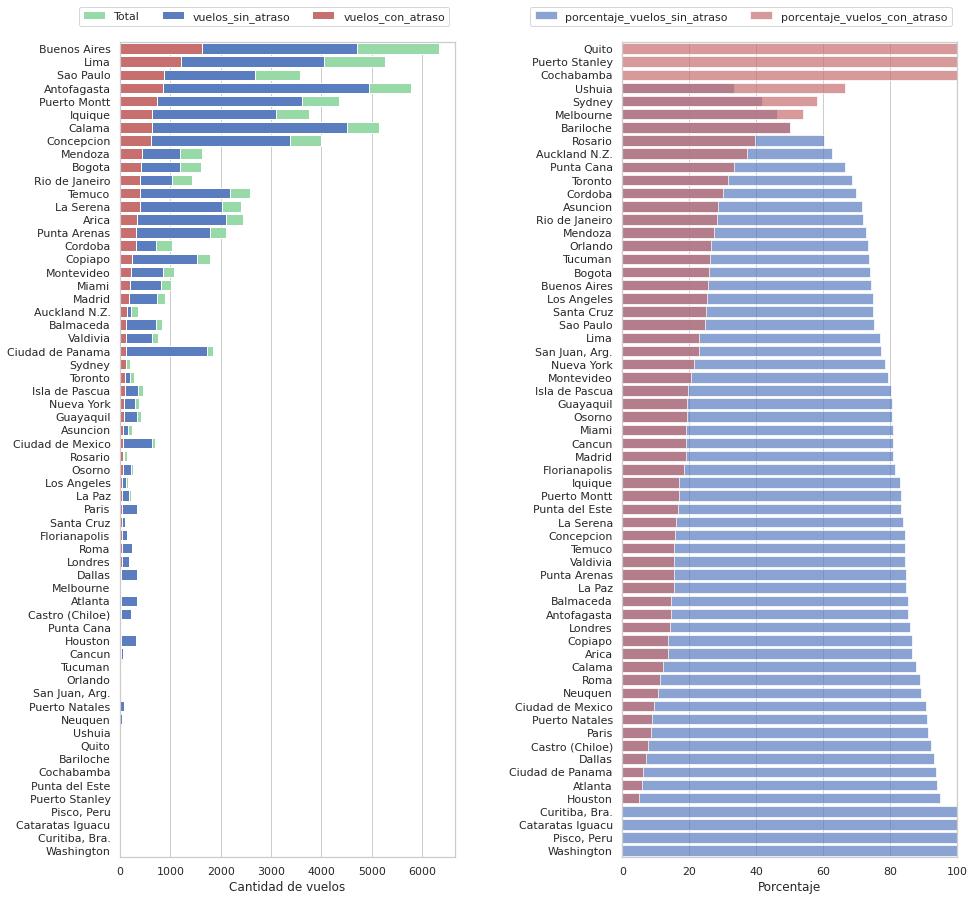

In [49]:
plot_absoluto_porcentual(df_atraso_por_destino, 'SIGLADES', 15, 15)

## 03.02. Tasa de atraso por aerolinea

In [50]:
df_atraso_por_aerolinea = dataframe_atraso_por(df_atraso, 'OPERA')
df_atraso_por_aerolinea

,OPERA,porcentaje_vuelos_con_atraso,porcentaje_vuelos_sin_atraso,vuelos_con_atraso,vuelos_sin_atraso,vuelos_total
0,Aerolineas Argentinas,24.01,75.99,468,1481,1949
1,Aeromexico,2.85,97.15,10,341,351
2,Air Canada,45.66,54.34,258,307,565
3,Air France,8.38,91.62,30,328,358
4,Alitalia,11.20,88.80,29,230,259
5,American Airlines,6.74,93.26,51,706,757
6,Austral,20.27,79.73,15,59,74
7,Avianca,26.56,73.44,306,846,1152
8,British Airways,14.15,85.85,29,176,205
9,Copa Air,6.27,93.73,116,1734,1850


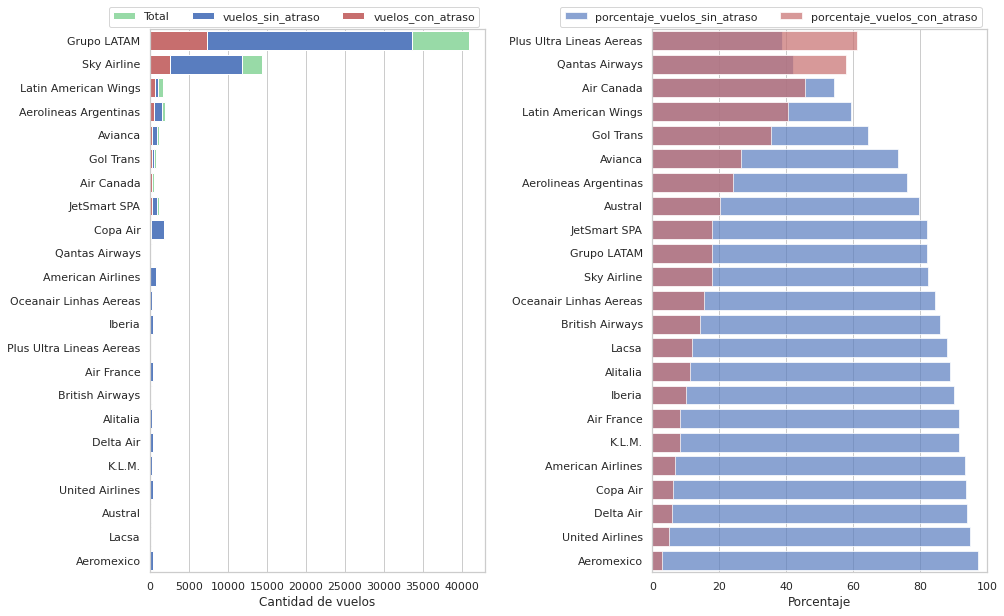

In [53]:
plot_absoluto_porcentual(df_atraso_por_aerolinea, "OPERA", 15, 10)

## 03.03. Tasa de atraso por mes del año

In [40]:
df_atraso_por_mes = dataframe_atraso_por(df_atraso, 'MES')
df_atraso_por_mes

,MES,porcentaje_vuelos_con_atraso,porcentaje_vuelos_sin_atraso,vuelos_con_atraso,vuelos_sin_atraso,vuelos_total
0,1,16.01,83.99,978,5130,6108
1,10,22.60,77.40,1363,4669,6032
2,11,19.72,80.28,1199,4881,6080
3,12,25.41,74.59,1615,4741,6356
4,2,15.16,84.84,843,4718,5561
5,3,11.51,88.49,631,4851,5482
6,4,11.65,88.35,585,4435,5020
7,5,15.78,84.22,827,4413,5240
8,6,17.10,82.90,852,4129,4981
9,7,29.34,70.66,1758,4234,5992


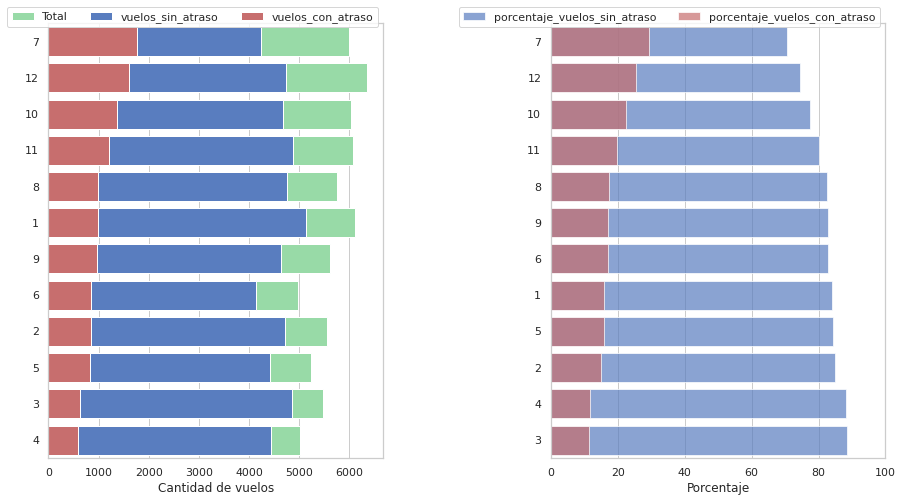

In [57]:
plot_absoluto_porcentual(df_atraso_por_mes, 'MES', 15, 8)

## 03.04. Tasa de atraso por día de la semana

In [59]:
df_atraso_por_dia_semana = dataframe_atraso_por(df_atraso, 'DIANOM')
df_atraso_por_dia_semana

,DIANOM,porcentaje_vuelos_con_atraso,porcentaje_vuelos_sin_atraso,vuelos_con_atraso,vuelos_sin_atraso,vuelos_total
0,Domingo,16.11,83.89,1578,8218,9796
1,Jueves,19.95,80.05,2045,8206,10251
2,Lunes,20.22,79.78,2048,8083,10131
3,Martes,16.91,83.09,1634,8028,9662
4,Miercoles,17.08,82.92,1661,8061,9722
5,Sabado,16.32,83.68,1363,6989,8352
6,Viernes,22.20,77.80,2285,8007,10292


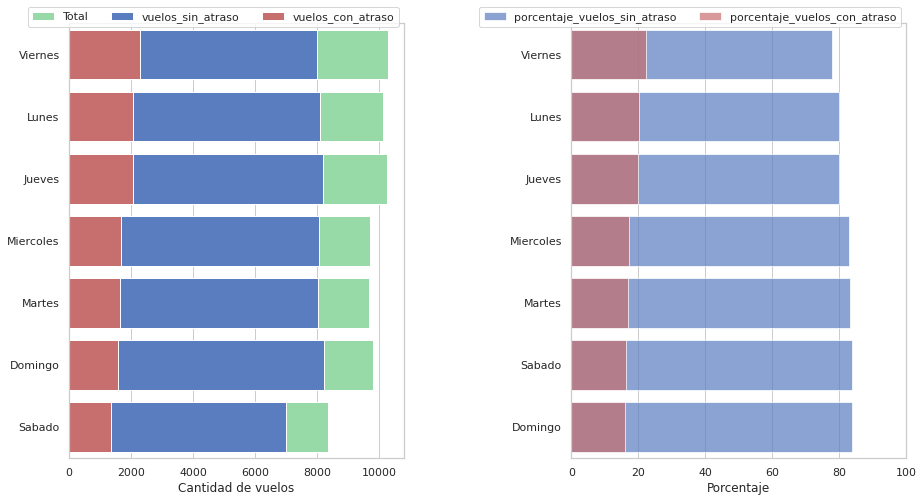

In [60]:
plot_absoluto_porcentual(df_atraso_por_dia_semana, 'DIANOM', 15, 8)

## 03.05. Tasa de atraso por temporada

In [69]:
df_atraso_por_temporada = dataframe_atraso_por(df_atraso, 'temporada_alta')
df_atraso_por_temporada

,temporada_alta,porcentaje_vuelos_con_atraso,porcentaje_vuelos_sin_atraso,vuelos_con_atraso,vuelos_sin_atraso,vuelos_total
0,0,17.92,82.08,8144,37300,45444
1,1,19.64,80.36,4470,18292,22762


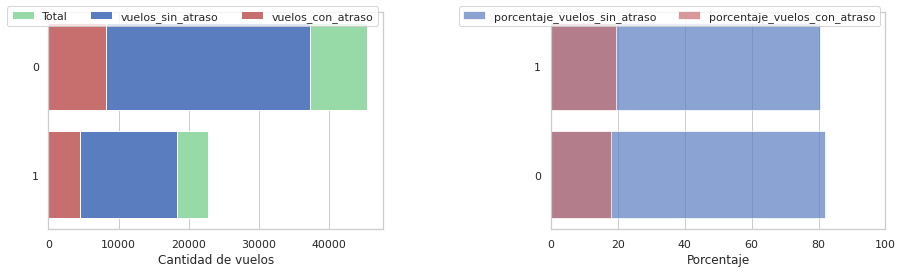

In [74]:
plot_absoluto_porcentual(df_atraso_por_temporada, 'temporada_alta', 15, 4)

## 03.06. Tasa de atraso por tipo de vuelo

In [79]:
df_atraso_por_tipo_vuelo = dataframe_atraso_por(df_atraso, 'TIPOVUELO')
df_atraso_por_tipo_vuelo

,TIPOVUELO,porcentaje_vuelos_con_atraso,porcentaje_vuelos_sin_atraso,vuelos_con_atraso,vuelos_sin_atraso,vuelos_total
0,I,22.56,77.44,7048,24192,31240
1,N,15.06,84.94,5566,31400,36966


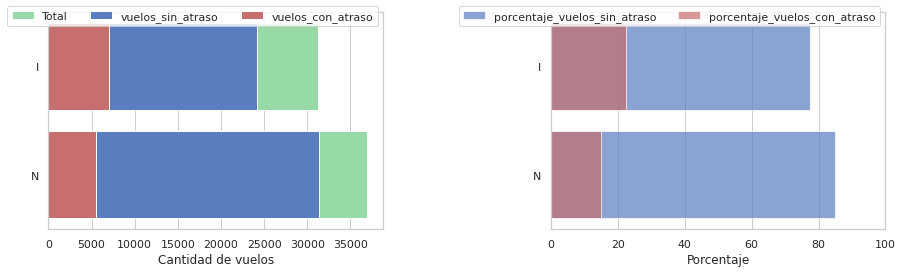

In [81]:
plot_absoluto_porcentual(df_atraso_por_tipo_vuelo, 'TIPOVUELO', 15, 4)

## 03.07. Expectativa en relación a las variables más influyentes en el modelo

In [84]:
df_raw

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68201,2017-12-22 14:55:00,400,SCEL,SPJC,JAT,2017-12-22 15:41:00,400.0,SCEL,SPJC,JAT,22,12,2017,Viernes,I,JetSmart SPA,Santiago,Lima
68202,2017-12-25 14:55:00,400,SCEL,SPJC,JAT,2017-12-25 15:11:00,400.0,SCEL,SPJC,JAT,25,12,2017,Lunes,I,JetSmart SPA,Santiago,Lima
68203,2017-12-27 14:55:00,400,SCEL,SPJC,JAT,2017-12-27 15:35:00,400.0,SCEL,SPJC,JAT,27,12,2017,Miercoles,I,JetSmart SPA,Santiago,Lima
68204,2017-12-29 14:55:00,400,SCEL,SPJC,JAT,2017-12-29 15:08:00,400.0,SCEL,SPJC,JAT,29,12,2017,Viernes,I,JetSmart SPA,Santiago,Lima


In [120]:
df_raw['Vlo-I'].nunique()

584

In [121]:
df_raw['Des-I'].nunique()

64

In [123]:
df_raw.nunique().reset

Fecha-I      53252
Vlo-I          584
Ori-I            1
Des-I           64
Emp-I           30
Fecha-O      62774
Vlo-O          861
Ori-O            1
Des-O           63
Emp-O           32
DIA             31
MES             12
AÑO              2
DIANOM           7
TIPOVUELO        2
OPERA           23
SIGLAORI         1
SIGLADES        62
dtype: int64

In [122]:
df_conteo = df_raw.groupby(['Des-I'], as_index=False).\
           agg(unique_col=('Vlo-I', lambda x: x.nunique()),
               conca=('Vlo-I', lambda x: ','.join(x.unique()))).\
           sort_values(by=['unique_col'], ascending=[False])
df_conteo

,Des-I,unique_col,conca
58,SPJC,67,"624,8099,8160,800,802,804,530,600,632,642,646,..."
40,SCFA,59,"140,142,150,156,160,162,164,166,14,120,122,124..."
48,SCTE,49,"1,11,13,15,21,23,25,57,65,67,89,257,259,261,26..."
37,SCCF,46,"120,122,128,130,132,134,140,142,144,146,148,15..."
33,SBGR,45,"7661,7663,8023,8027,8029,8069,8073,8161,9601,9..."
...,...,...,...
45,SCPQ,1,69
24,SANU,1,7896
25,SARI,1,1261
27,SAZN,1,7899


In [126]:
df.columns

Index(['Fecha-I', 'Vlo-I', 'Ori-I', 'Des-I', 'Emp-I', 'Fecha-O', 'Vlo-O',
       'Ori-O', 'Des-O', 'Emp-O', 'DIA', 'MES', 'AÑO', 'DIANOM', 'TIPOVUELO',
       'OPERA', 'SIGLAORI', 'SIGLADES', 'temporada_alta', 'dif_min',
       'atraso_15', 'periodo_dia'],
      dtype='object')

In [127]:
columnas_modelo = ['Des-I', 'Emp-I',
                   'DIA', 'MES', 'DIANOM', 'TIPOVUELO', 
                   'temporada_alta','periodo_dia', 'atraso_15']

In [128]:
df_modelo = df[columnas_modelo]
df_modelo.head()

,Des-I,Emp-I,DIA,MES,DIANOM,TIPOVUELO,temporada_alta,periodo_dia,atraso_15
0,KMIA,AAL,1,1,Domingo,I,1,noche,0
1,KMIA,AAL,2,1,Lunes,I,1,noche,0
2,KMIA,AAL,3,1,Martes,I,1,noche,0
3,KMIA,AAL,4,1,Miercoles,I,1,noche,0
4,KMIA,AAL,5,1,Jueves,I,1,noche,0


In [130]:
df_modelo.atraso_15.value_counts(normalize=True)

0    0.81506
1    0.18494
Name: atraso_15, dtype: float64

In [134]:
df_modelo.to_csv('df_modelo.csv', sep=',', index=False, encoding='utf-8')

In [125]:
df.head(3)

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,temporada_alta,dif_min,atraso_15,periodo_dia
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,...,2017,Domingo,I,American Airlines,Santiago,Miami,1,3.0,0,noche
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,...,2017,Lunes,I,American Airlines,Santiago,Miami,1,9.0,0,noche
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,...,2017,Martes,I,American Airlines,Santiago,Miami,1,9.0,0,noche


In [111]:
df_conteo = df_raw.groupby(['Vlo-I'], as_index=False).\
           agg(unique_col=('Des-I', lambda x: x.nunique()),
               conca=('Des-I', lambda x: ','.join(x.unique()))).\
           sort_values(by=['unique_col'], ascending=[True])
df_conteo

,Vlo-I,unique_col,conca
0,1,2,"SCTE,SCNT"
1,10,1,SCCF
2,100,1,SCSE
3,1003,1,SAEZ
4,1004,1,SACO
...,...,...,...
579,99,1,SCCI
580,991,1,SCCI
581,993,1,SCCI
582,9955,1,SBGR


In [114]:
df_conteo = df_raw.groupby(['Vlo-I', 'Des-I' ], as_index=False).\
           agg(unique_col=('Des-I', 'count')).\
           sort_values(by=['Vlo-I'], ascending=[True])
df_conteo

,Vlo-I,Des-I,unique_col
0,1,SCNT,46
1,1,SCTE,361
2,10,SCCF,39
3,100,SCSE,20
4,1003,SAEZ,3
...,...,...,...
738,99,SCCI,17
739,991,SCCI,9
740,993,SCCI,3
741,9955,SBGR,1


In [115]:
counts =  df_conteo['Vlo-I'].value_counts()

# Filtrar los resultados para mostrar sólo las categorías que aparecen más de una vez
duplicates = counts[counts > 1]

# Obtener una lista con las categorías duplicadas
duplicates_list = list(duplicates.index)
duplicates_list

['1102',
 '1236',
 '1241',
 '1239',
 '1230',
 '1238',
 '1106',
 '702',
 '1244',
 '1165',
 '1235',
 '1101',
 '146',
 '1107',
 '9',
 '1108',
 '112',
 '124',
 '87',
 '156',
 '158',
 '1237',
 '160',
 '154',
 '1242',
 '162',
 '164',
 '1',
 '152',
 '168',
 '89',
 '122',
 '17',
 '503',
 '28',
 '120',
 '281',
 '283',
 '502',
 '7813',
 '289',
 '1188',
 '7811',
 '166',
 '386',
 '53',
 '57',
 '138',
 '134',
 '59',
 '140',
 '251',
 '132',
 '1302',
 '602',
 '1300',
 '130',
 '81',
 '1291',
 '142',
 '1283',
 '50',
 '1281',
 '128',
 '144',
 '61',
 '83',
 '55',
 '1261',
 '1260',
 '126',
 '15',
 '534',
 '150',
 '1250',
 '136',
 '118',
 '912',
 '9461',
 '1122',
 '451',
 '4503',
 '4501',
 '45',
 '295',
 '400',
 '9615',
 '33',
 '1104',
 '1103',
 '4000',
 '110',
 '11',
 '2297',
 '1071',
 '75',
 '43',
 '73',
 '9689',
 '71',
 '41',
 '704',
 '1124',
 '1357',
 '455',
 '461',
 '3',
 '176',
 '116',
 '1166',
 '302',
 '93',
 '1167',
 '9245',
 '180',
 '184',
 '182',
 '31',
 '186',
 '188',
 '1132',
 '1130',
 '174']

In [118]:
df_conteo[df_conteo['Vlo-I'].isin(duplicates_list)].head(50)

,Vlo-I,Des-I,unique_col
0,1,SCNT,46
1,1,SCTE,361
24,1071,SAEZ,1
25,1071,SCIE,1
31,11,MMMX,347
32,11,SCTE,298
33,110,SCAT,319
34,110,SCDA,15
35,1101,SAEZ,2
36,1101,SCQP,1


In [112]:
df_conteo[df_conteo.unique_col>1]

,Vlo-I,unique_col,conca
0,1,2,"SCTE,SCNT"
23,1071,2,"SCIE,SAEZ"
29,11,2,"MMMX,SCTE"
30,110,2,"SCAT,SCDA"
31,1101,3,"SCTE,SCQP,SAEZ"
...,...,...,...
530,9245,2,"SBGL,SBGR"
537,93,2,"CYYZ,SCCI"
547,9461,2,"SAAR,SBGR"
555,9615,2,"SBGR,SBGL"


In [88]:
df_raw.groupby(['Ori-I'], as_index=False).\
           agg(unique_col=('SIGLAORI', lambda x: x.nunique()),
               conca=('SIGLAORI', lambda x: ','.join(x.unique()))).\
           sort_values(by=['Ori-I'], ascending=[True])

,Ori-I,unique_col,conca
0,SCEL,1,Santiago


In [105]:
df_raw.columns

Index(['Fecha-I', 'Vlo-I', 'Ori-I', 'Des-I', 'Emp-I', 'Fecha-O', 'Vlo-O',
       'Ori-O', 'Des-O', 'Emp-O', 'DIA', 'MES', 'AÑO', 'DIANOM', 'TIPOVUELO',
       'OPERA', 'SIGLAORI', 'SIGLADES'],
      dtype='object')

In [107]:
df_raw.groupby(['Emp-I'], as_index=False).\
           agg(unique_col=('OPERA', lambda x: x.nunique()),
               conca=('OPERA', lambda x: ','.join(x.unique()))).\
           sort_values(by=['Emp-I'], ascending=[True])

,Emp-I,unique_col,conca
0,AAL,1,American Airlines
1,ACA,1,Air Canada
2,AFR,1,Air France
3,AMX,1,Aeromexico
4,ARG,1,Aerolineas Argentinas
5,AUT,1,Austral
6,AVA,1,Avianca
7,AZA,1,Alitalia
8,BAW,1,British Airways
9,CMP,1,Copa Air


In [92]:
df_conteo = df_raw.groupby(['Des-I'], as_index=False).\
           agg(unique_col=('SIGLADES', lambda x: x.nunique()),
               conca=('SIGLADES', lambda x: ','.join(x.unique()))).\
           sort_values(by=['Des-I'], ascending=[True])
df_conteo

,Des-I,unique_col,conca
0,CYYZ,1,Toronto
1,EGLL,1,Londres
2,EGYP,1,Puerto Stanley
3,KATL,1,Atlanta
4,KDFW,1,Dallas
...,...,...,...
59,SPSO,1,"Pisco, Peru"
60,SULS,1,Punta del Este
61,SUMU,1,Montevideo
62,YMML,1,Melbourne


In [94]:
df_conteo[df_conteo.unique_col>1]

,Des-I,unique_col,conca
5,KIAH,2,"Houston,Washington"
6,KJFK,2,"Nueva York,Miami"
33,SBGR,2,"Sao Paulo,Rio de Janeiro"
36,SCBA,2,"Balmaceda,Puerto Montt"
38,SCCI,2,"Punta Arenas,Puerto Montt"
40,SCFA,2,"Antofagasta,Calama"
41,SCIE,3,"Concepcion,Temuco,Puerto Montt"
48,SCTE,3,"Puerto Montt,Temuco,Punta Arenas"
50,SEGU,2,"Guayaquil,Buenos Aires"
63,YSSY,2,"Sydney,Melbourne"


In [95]:
df_conteo = df_raw.groupby(['Des-I', 'SIGLADES' ], as_index=False).\
           agg(unique_col=('SIGLADES', 'count')).\
           sort_values(by=['Des-I'], ascending=[True])
df_conteo

,Des-I,SIGLADES,unique_col
0,CYYZ,Toronto,283
1,EGLL,Londres,205
2,EGYP,Puerto Stanley,1
3,KATL,Atlanta,358
4,KDFW,Dallas,357
...,...,...,...
71,SULS,Punta del Este,6
72,SUMU,Montevideo,1066
73,YMML,Melbourne,38
74,YSSY,Melbourne,1


In [103]:
counts =  df_conteo['Des-I'].value_counts()

# Filtrar los resultados para mostrar sólo las categorías que aparecen más de una vez
duplicates = counts[counts > 1]

# Obtener una lista con las categorías duplicadas
duplicates_list = list(duplicates.index)
duplicates_list

['SCIE',
 'SCTE',
 'YSSY',
 'SBGR',
 'SCBA',
 'SCCI',
 'SCFA',
 'SEGU',
 'KIAH',
 'KJFK']

In [104]:
df_conteo[df_conteo['Des-I'].isin(duplicates_list)]

,Des-I,SIGLADES,unique_col
5,KIAH,Houston,334
6,KIAH,Washington,1
8,KJFK,Nueva York,382
7,KJFK,Miami,1
35,SBGR,Rio de Janeiro,1
36,SBGR,Sao Paulo,3569
39,SCBA,Balmaceda,839
40,SCBA,Puerto Montt,4
42,SCCI,Puerto Montt,1
43,SCCI,Punta Arenas,2104


In [102]:
duplicates = df_conteo['Des-I' ].value_counts()>1).index()

TypeError: ignored

In [93]:
22508/(45698+22508)

0.33000029322933466

- Periodo del dia: 3 (mañana, tarde y noche)
- Temporada alta: 2 
- Dia de la semana: 7
- Mes: 12
- Codigo Aerolinea: 